In [52]:
from Training import DataCreateUpdated as dc
import numpy as np
import matplotlib.pyplot as plt

rec_paths = ["OpenBCI-RAW-2021-12-02_19-19-53.txt", 
                "OpenBCI-RAW-2021-12-02_19-31-12.txt", 
                "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_JawClench_2\OpenBCI-RAW-2022-02-16_19-30-28.txt"]
label_paths = ["JawClench_labels_Ansh_12-02-21-1918.txt", 
                "JawClench_labels_Ansh_12-02-21-1930.txt", 
                "Recordings\Spring_2022\Evan_JawClench_1.txt"]
label_types = ["JAW_CLENCH", 
                "JAW_CLENCH", 
                "JAW_CLENCH"]

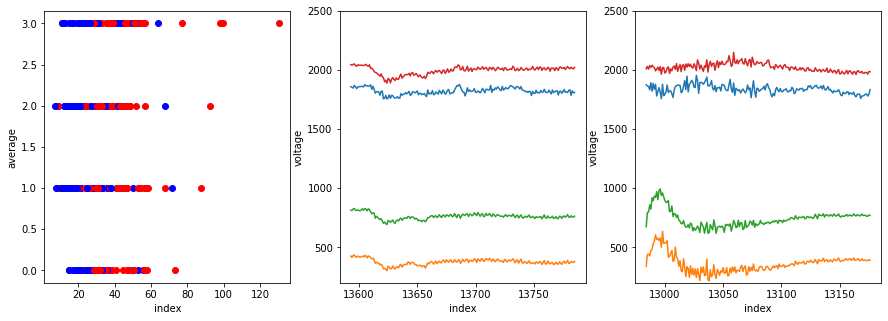

In [53]:
# Data visualization for the sample data at index sdi
# Go to next block for actual code
sdi = 0
sample_obs = dc.getObservations(rec_paths[sdi], label_paths[sdi], 1000, [0,1,2,3], label_types[sdi])

sample_y_channels_groups, sample_ind_groups, sample_t_groups, sample_l_groups = sample_obs

na_ind = 0 #non-action
a_ind = 13 #action

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.xlabel('index')
plt.ylabel('average')

colorgood = 'blue'
colorbad = 'red'
pos = -1
for channel_groups in sample_y_channels_groups:
    pos = (pos+1)%4
    for i in range(channel_groups.shape[0]):
        if(sample_l_groups[i][0] == 0):
            color = colorbad
            na_ind = i
        else:
            color = colorgood
            a_ind = i
        plt.plot(np.mean(np.abs(channel_groups[i] - np.ones_like(channel_groups[i]) * np.mean(channel_groups[i]))), pos, 'o', color = color)

plt.subplot(1,3,2)
plt.xlabel('index')
plt.ylabel('voltage')
plt.ylim(200, 2500)
for channel_groups in sample_y_channels_groups:
    plt.plot(sample_ind_groups[a_ind], channel_groups[a_ind])


plt.subplot(1,3,3)
plt.xlabel('index')
plt.ylabel('voltage')
plt.ylim(200, 2500)
for channel_groups in sample_y_channels_groups:
    plt.plot(sample_ind_groups[na_ind], channel_groups[na_ind])

In [54]:
# ACTUAL CODE STARTS HERE
from sklearn import svm

inputsToUse = np.arange(len(rec_paths))
inputsToUse = [0, 1]
X = None
ProcessedX = None
y = None
for i in inputsToUse:
    obs = dc.getObservations(rec_paths[i], label_paths[i], 1000, [0,1,2,3], label_types[i])
    y_channels_groups, ind_groups, t_groups, l_groups = obs
    if X is not None:
        X = np.concatenate((X, np.transpose(np.mean(y_channels_groups, axis=2))))
        ProcessedX = np.concatenate((ProcessedX, np.transpose(np.mean(np.abs(y_channels_groups - np.mean(y_channels_groups, axis=2, keepdims=True)), axis=2))))
        y = np.concatenate((y, l_groups))
    else:
        X = np.transpose(np.mean(y_channels_groups, axis=2))
        ProcessedX = np.transpose(np.mean(np.abs(y_channels_groups - np.mean(y_channels_groups, axis=2, keepdims=True)), axis=2))
        y = l_groups

#Using both mean and deviation
# X = np.concatenate((X, ProcessedX), axis = 1)
#Using just mean deviation
X = ProcessedX

print(X.shape, y.shape)

#test-train split
from sklearn.model_selection import train_test_split

X_res, X_test, y_res, y_test = train_test_split(X, y, test_size=0.33, random_state = 4)
X = X_res
y = y_res


#Enables first n classifiers (including the no action classifier)
num_enabled = 2 # Max should be y.shape[1]

# Create as many classifiers as needed
classifiers = []
for i in range(0, num_enabled):
    classifiers.append(svm.SVC(probability=True))
    classifiers[i].fit(X, y[:,i])

(138, 4) (138, 5)


In [55]:
correct = 0
total = 0

enabledClassifiers = np.arange(0, y.shape[1])[:num_enabled]
RecallRate =np.zeros([2, num_enabled])
Precision = np.zeros([2, num_enabled])

# If you want to test on all data rather than just test set
# X = np.concatenate((X_test, X))
# y = np.concatenate((y_test, y))

X = X_test
y = y_test

for i in range(X.shape[0]):
    maxVal = 0.0
    maxInd = 0

    #Enable as many classifiers as you need to
    for c in enabledClassifiers:
        if(classifiers[c].predict_proba(X[i].reshape(1, -1))[0][1]>maxVal):
            maxVal = classifiers[c].predict_proba(X[i].reshape(1, -1))[0][1]
            maxInd = c

#Getting Precision and Recall Data
    if(y[i][maxInd]==1):
        correct+=1
        Precision[maxInd][0]+=1
        RecallRate[maxInd][0]+=1
    for xx in range(num_enabled):
        if(y[i][xx]==1):
            RecallRate[xx][1]+=1
    total+=1
    Precision[maxInd][1]+=1
print(correct/total)
print("Recall")
for row in RecallRate:
    print(row, row[0]/row[1])
print("Precision")
for row in Precision:
    print(row, row[0]/row[1])

0.6304347826086957
Recall
[22. 26.] 0.8461538461538461
[ 7. 20.] 0.35
Precision
[22. 35.] 0.6285714285714286
[ 7. 11.] 0.6363636363636364
